In [3]:
import pandas as pd 
import numpy as np
import statistics
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots
import statsmodels.tsa.arima_process as arima_process 

from numpy import cov
from random import shuffle 
%pip install category_encoders
from category_encoders import TargetEncoder

from matplotlib.pyplot import figure
from matplotlib import pyplot
import matplotlib.pyplot as plt

#from sklearn.preprocessing import StandardScalar
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.inspection import permutation_importance


from statsmodels.tsa.filters.filtertools import convolution_filter
from statsmodels.tsa.seasonal import _extrapolate_trend, seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")

Note: you may need to restart the kernel to use updated packages.


In [4]:
pd.set_option("display.max_columns", None)
df = pd.read_csv(r"C:\Users\n8mau\OneDrive\Desktop\Professional Certificate in Machine Learning and Artificial Intelligence\Module 11\Vehicles_Nate_Mauer.csv")
df.head(3)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl


In [5]:
percent_null = df.isnull().sum() * 100 / len(df)
missing_df = pd.DataFrame({"col_name" : df.columns, 
                          "percent_null" : np.round(percent_null, 2)})
missing_df

,col_name,percent_null
id,id,0.00
region,region,0.00
price,price,0.00
year,year,0.28
manufacturer,manufacturer,4.13
model,model,1.24
condition,condition,40.79
cylinders,cylinders,41.62
fuel,fuel,0.71
odometer,odometer,1.03


[Text(0.5, 0, 'Column Name'),
 Text(0, 0.5, 'Percent Null'),
 Text(0.5, 1.0, 'Percent Null by Column')]

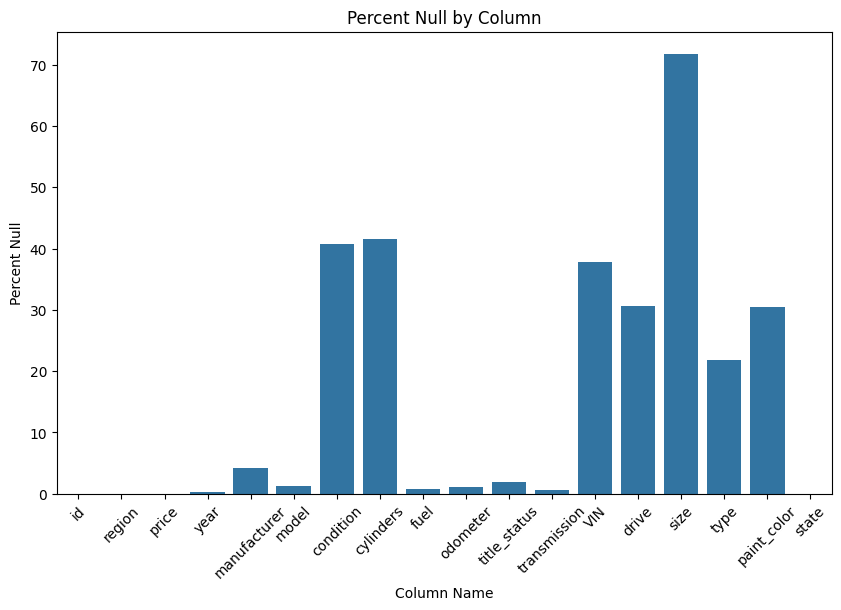

In [6]:
plt.figure(figsize = (10, 6))
fig = sns.barplot(x = "col_name", y = "percent_null", data = missing_df)
plt.xticks(rotation = 45)

fig.set(xlabel = "Column Name", ylabel = "Percent Null", title = "Percent Null by Column")

In [8]:
df.dropna(subset=['year', 'manufacturer', 'model', 'fuel', 'odometer', 'title_status', 'transmission'], inplace = True) 

In [9]:
df["condition"].fillna(df["condition"].mode().to_string(), inplace = True)
df["cylinders"].fillna(df["cylinders"].mode().to_string(), inplace = True)
df["drive"].fillna(df["drive"].mode().to_string(), inplace = True)
df["size"].fillna(df["size"].mode().to_string(), inplace = True)
df["type"].fillna(df["type"].mode().to_string(), inplace = True)
df["paint_color"].fillna(df["paint_color"].mode().to_string(), inplace = True)

In [10]:
te = TargetEncoder()
encoded_df = te.fit_transform(df[["region", "manufacturer", "model", "type", "paint_color", "state", "fuel", "drive", "transmission"]], df["price"])

In [11]:
df.drop(['region', 'manufacturer', 'model', 'type', 'paint_color', 'state',
       'fuel', 'drive', 'transmission'], axis = 1, inplace = True)
df = pd.concat([df, encoded_df], axis = 1)
df.shape

(389604, 18)

In [12]:
df = df[df["size"] != '0    4']
df["size"].replace({"0    full-size" : 4, "full-size" : 4, "mid-size" : 3, "compact" : 2, "sub-compact" : 1}, inplace = True)

In [13]:
df["paint_color"].replace({"0    white" : "white"}, inplace = True)

In [14]:
df = df[df["condition"] != '0    good']
df["condition"].replace({"new" : 6, "excellent" : 5, "like new" : 4, "good" : 3, "fair" : 2, "salvage" : 1}, inplace = True)

In [15]:
df["condition"] = df["condition"].astype(int)

In [16]:
df = df[df["cylinders"] != "0    6"]
df["cylinders"].replace({"8 cylinders" : 8, "6 cylinders" : 6, "0    6 cylinders" : 6, \
                         "5 cylinders" : 5, "4 cylinders" : 4, "10 cylinders" : 10, \
                         "3 cylinders" : 3, "12 cylinders" : 12, "other" : 6}, inplace = True)

In [17]:
df["title_status"].replace({"clean" : 6, "lien" : 5, "rebuilt" : 4, "missing" : 3, "salvage" : 2, "parts only" : 1}, inplace = True)

In [18]:
df = df.convert_dtypes()

In [19]:
df = df[(df["price"] >= 150) & (df["price"] <= 70000)]

In [20]:
df.shape

(220800, 18)

In [21]:
df.agg(["skew"]).transpose()

,skew
id,-0.630330
price,0.789593
year,-3.222202
condition,0.189426
cylinders,0.100428
odometer,43.495808
title_status,-5.945284
size,-2.572930
region,10.005777
manufacturer,3.092386


[Text(0.5, 1.0, 'Distribution of Price')]

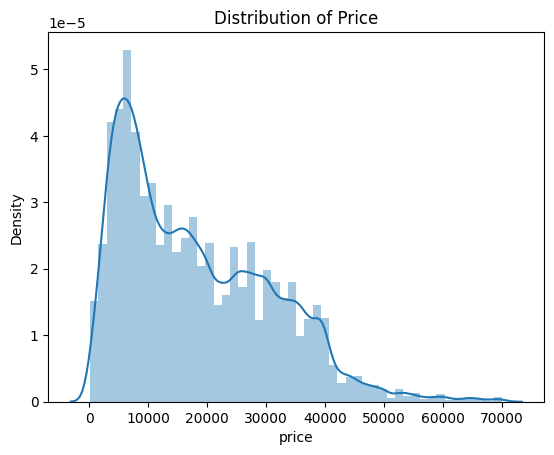

In [22]:
sns.distplot(df['price']).set(title = "Distribution of Price")

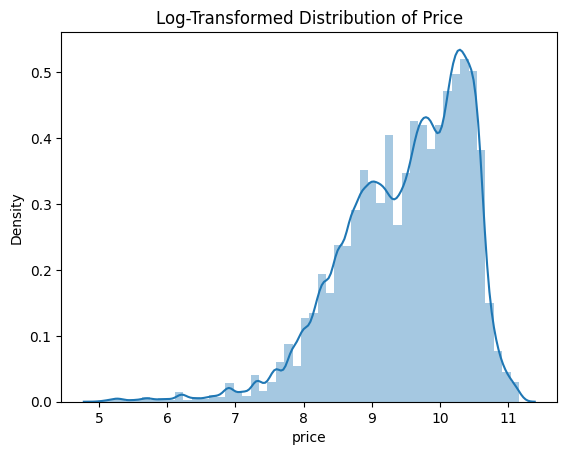

In [23]:
df['price'] = np.log(df['price'])

sns.distplot(df['price']).set(title = 'Log-Transformed Distribution of Price');

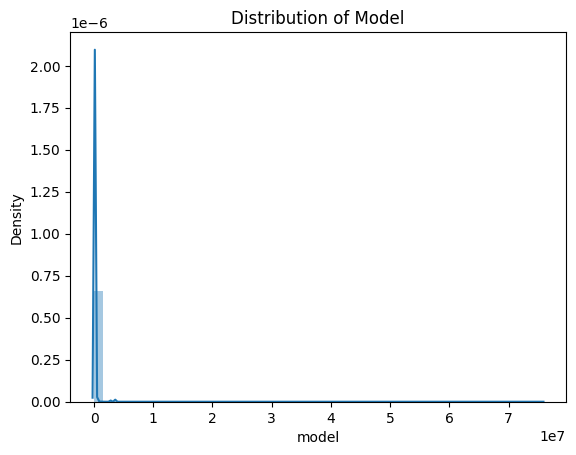

In [24]:
sns.distplot(df['model']).set(title = 'Distribution of Model');

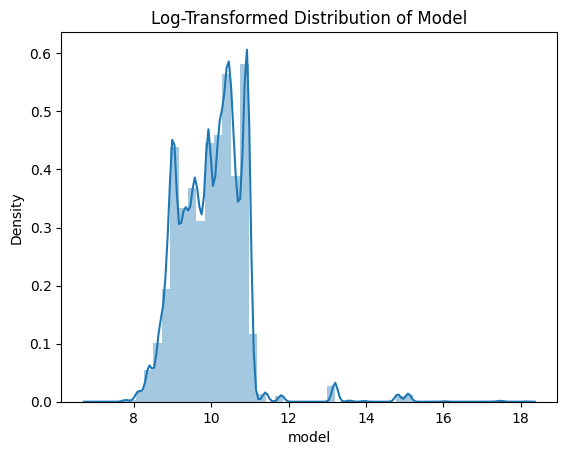

In [25]:
df['model'] = np.log(df['model'])

sns.distplot(df['model']).set(title = 'Log-Transformed Distribution of Model');

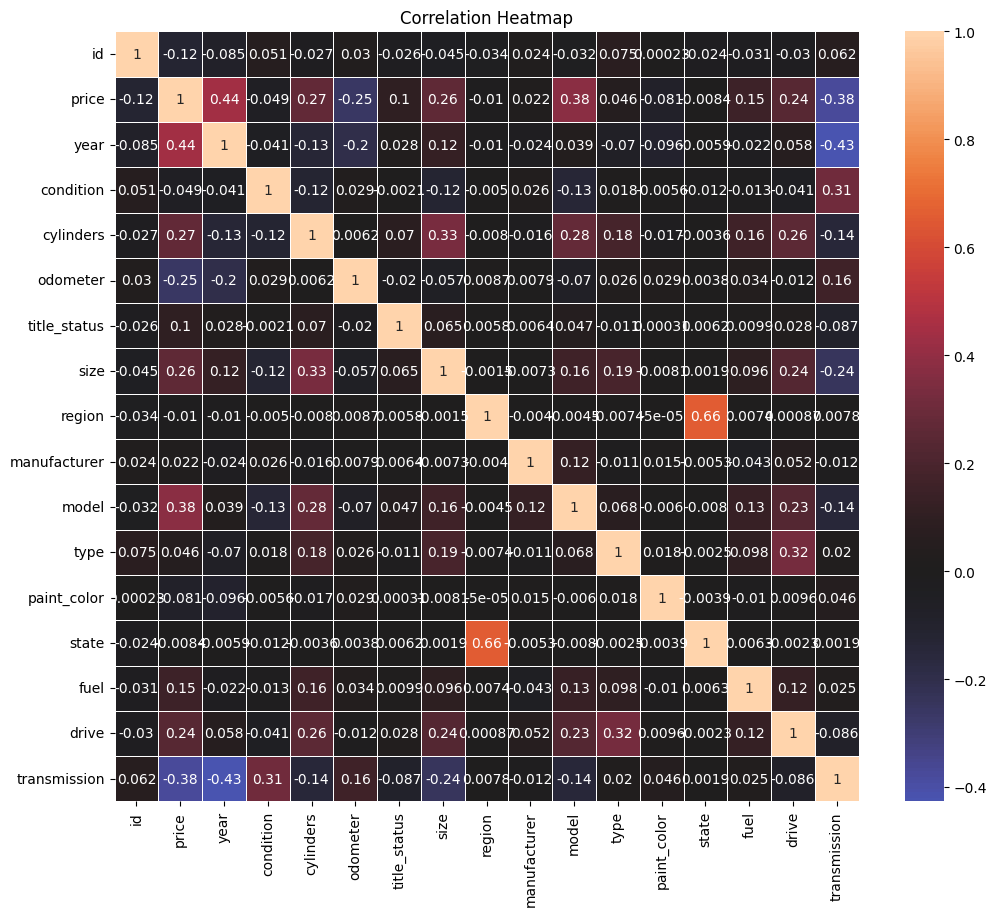

In [26]:
sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(df.corr(), center = 0, linewidth = .5, annot = True).set(title='Correlation Heatmap');

In [27]:
X = df.drop(["price", "VIN"], axis = 1)
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = .3)

In [28]:
sfs = SequentialFeatureSelector(estimator = LinearRegression(),
                                scoring = "neg_mean_squared_error",
                                cv = 5,
                                n_features_to_select = 10)

Sequential Feature Selection

In [29]:
sfs.fit(X, y)

SequentialFeatureSelector(estimator=LinearRegression(), n_features_to_select=10,
                          scoring='neg_mean_squared_error')

In [30]:
sfs.get_feature_names_out(input_features=None)

array(['id', 'year', 'condition', 'cylinders', 'odometer', 'size',
       'model', 'fuel', 'drive', 'transmission'], dtype=object)

In [31]:
final_df = df[['id', 'year', 'condition', 'cylinders', 'odometer', 'size',
       'model', 'fuel', 'drive', 'transmission', 'price']]

#Linear Regression Model
MSE of 0.462

In [32]:
lr = LinearRegression(fit_intercept = True)
lr_model = lr.fit(X_train, y_train)

In [33]:
lr_mse = mean_squared_error(lr_model.predict(X_test), y_test)
print(f"MSE of linear regression model is {np.round(lr_mse, 3)}")

MSE of linear regression model is 0.462


Cross Validation

In [34]:
def simple_cross_validation(X_train, y_train, X_test, y_test):
    best_pipe = None
    best_mse = np.inf

    for complexity in range(1, 6):
        pipe = Pipeline([
            ("transform", PolynomialFeatures(degree = complexity, include_bias = False)),
            ("scaler", StandardScaler()),
            ("regression", LinearRegression())
        ])

        pipe.fit(X_train, y_train)
        
        test_mse = mean_squared_error(pipe.predict(X_test), y_test)

        if test_mse < best_mse:
            best_mse = test_mse
            best_pipe = pipe
    return best_pipe

In [37]:
best_lr_model = simple_cross_validation(X_train, y_train, X_test, y_test)
best_lr_model.get_params()

In [2]:
from sklearn.metrics import mean_squared_error
lr3_mse = mean_squared_error(y_test, best_lr_model.predict(X_test))
print(f"MSE for Linear Regression model of degree 3 is {lr3_mse}")

NameError: name 'y_test' is not defined

Lasso Regression Model with GridSearchCV

In [ ]:
alphas = {"lasso__alpha" : [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

In [ ]:
lasso_pipe = Pipeline([
    ("transform", PolynomialFeatures(degree = 3, include_bias = False)),
    ("scale", StandardScaler()),
    ("lasso", Lasso())
])

In [ ]:
lasso_grid = GridSearchCV(estimator = lasso_pipe,
                            param_grid = alphas,
                            scoring = "neg_mean_squared_error",
                            cv = 3)    

In [ ]:
lasso_grid.fit(X, y)

In [ ]:
lasso_grid.best_params_

In [ ]:
lasso_grid.best_score_

Ridge Regression Model using GridSearchCV

In [ ]:
alphas = {"ridge__alpha" : [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]}

In [ ]:
ridge_pipe = Pipeline([
    ("transform", PolynomialFeatures(degree = 3, include_bias = False)),
    ("scale", StandardScaler()),
    ("ridge", Ridge())
])

In [ ]:
ridge_grid = GridSearchCV(estimator = ridge_pipe,
                            param_grid = alphas,
                            scoring = "neg_mean_squared_error",
                            cv = 3)  

In [ ]:
ridge_grid.fit(X, y) 

In [ ]:
ridge_grid.best_params_

In [ ]:
ridge_grid.best_score_